In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler

In [36]:
#merging for BDT training
node_6=pd.read_hdf("node_6.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_SM=pd.read_hdf("node_SM.hd5")

frames=[node_6,node_4,node_SM]
df=pd.concat(frames)

#ignoring category 0
df=df[df.cat>0]
df.weight/=df.weight.mean()

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df["random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)

In [37]:
df.columns

Index([u'candidate_id', u'weight', u'mgg', u'mbb', u'leadPho_px',
       u'leadPho_py', u'leadPho_pz', u'leadPho_e', u'subleadPho_px',
       u'subleadPho_py', u'subleadPho_pz', u'subleadPho_e', u'leadJet_px',
       u'leadJet_py', u'leadJet_pz', u'leadJet_e', u'subleadJet_px',
       u'subleadJet_py', u'subleadJet_pz', u'subleadJet_e', u'rho', u'nvtx',
       u'event', u'lumi', u'processIndex', u'run', u'npu', u'puweight', u'cat',
       u'bdtcat', u'mxcat', u'leadPho_pt', u'leadPho_eta', u'leadPho_phi',
       u'leadPho_m', u'subleadPho_pt', u'subleadPho_eta', u'subleadPho_phi',
       u'subleadPho_m', u'leadJet_pt', u'leadJet_eta', u'leadJet_phi',
       u'leadJet_m', u'subleadJet_pt', u'subleadJet_eta', u'subleadJet_phi',
       u'subleadJet_m', u'hgg_px', u'hgg_py', u'hgg_pz', u'hgg_e', u'hgg_pt',
       u'hgg_eta', u'hgg_phi', u'hgg_m', u'hbb_px', u'hbb_py', u'hbb_pz',
       u'hbb_e', u'hbb_pt', u'hbb_eta', u'hbb_phi', u'hbb_m', u'hh_px',
       u'hh_py', u'hh_pz', u'hh_e', u'hh

In [38]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

In [39]:
#finding sum, count, mean of each category in weights column
df.groupby('cat')['weight'].agg(['sum','count','mean'])

,sum,count,mean
cat,,,
1,7353.071144,7354,0.999874
2,6796.984495,6919,0.982365
3,1969.616944,2039,0.965972
4,353.156220,369,0.957063
5,1399.729497,1336,1.047702
6,2463.990999,2440,1.009832
7,1589.424430,1626,0.977506
8,544.508166,569,0.956956
9,1345.193675,1258,1.069311


In [40]:
X = df[features]
y = df['cat'] 
w = df['weight']

scaler=RobustScaler()

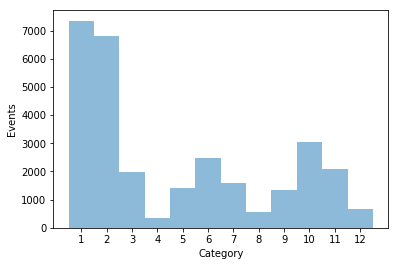

In [41]:
#plotting truth histogram
plt.figure(2)
bins=np.arange(0.5,13.5)
plt.hist(y,weights=w,bins=bins,alpha=0.5)
h=np.histogram(y,weights=w,bins=bins)
plt.ylabel('Events')
plt.xlabel('Category')
plt.xticks(np.arange(1,13))
plt.show()
plt.close()

In [8]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#classifier fitted to training set 
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf.joblib') 

CPU times: user 7min 9s, sys: 3.64 s, total: 7min 13s
Wall time: 54.3 s


['clf.joblib']

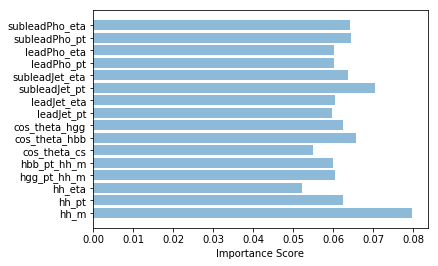

In [9]:
#features importance
clf=joblib.load('clf.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [10]:
#reweighting and clipping it at 10
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,10)
w_train*=rw[y_train-1]

np.savetxt('rw_10.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_10.joblib') 

CPU times: user 7min 10s, sys: 2.84 s, total: 7min 13s
Wall time: 54.3 s


['clf_10.joblib']

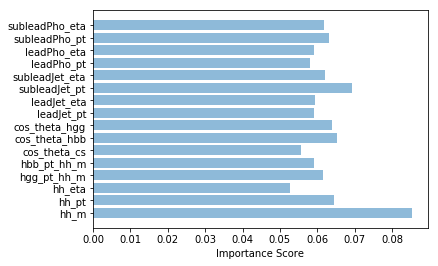

In [11]:
#features importance
clf=joblib.load('clf_10.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [31]:
result=pd.read_hdf("optimisation_accu_6.hd5")
print "Best accuracy"
print result[0:1]

Best accuracy
    clip_weight  learning_rate  max_depth  min_child_weight  n_estimators  \
44           20            0.5         10                20           300   

    reg_lambda  subsample  accu_mean  accu_stdev  cross_mean       ...        \
44         2.0        0.8     0.5296    0.003646    1.878062       ...         

    cross_mean_6  cross_stdev_6  accu_mean_9  accu_stdev_9  cross_mean_9  \
44      1.442199       0.044201     0.325602      0.004062      3.783617   

    cross_stdev_9  accu_mean_SM  accu_stdev_SM  cross_mean_SM  cross_stdev_SM  
44       0.052676      0.691966       0.007782       1.105245        0.028387  

[1 rows x 27 columns]


In [34]:
result=pd.read_hdf("optimisation_cross_9.hd5")
print "Best entropy"
print result[0:1]

Best entropy
    clip_weight  learning_rate  max_depth  min_child_weight  n_estimators  \
40           30            0.1          3               200           300   

    reg_lambda  subsample  accu_mean  accu_stdev  cross_mean       ...        \
40         2.0        1.0   0.560012    0.005602    1.193947       ...         

    cross_mean_6  cross_stdev_6  accu_mean_9  accu_stdev_9  cross_mean_9  \
40      1.560514       0.025539      0.29887      0.007581       2.56976   

    cross_stdev_9  accu_mean_SM  accu_stdev_SM  cross_mean_SM  cross_stdev_SM  
40       0.055388      0.514969       0.006186       1.431611        0.022734  

[1 rows x 27 columns]


In [44]:
#optimised based on accuracy for SM and 9 
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,10)
w_train*=rw[y_train-1]

np.savetxt('rw_accuSM9.txt',rw)

clf=XGBClassifier(learning_rate=0.5, reg_lambda=10, subsample=0.6, max_depth=10, n_estimators=500, 
                  min_child_weight=20, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_accuSM9.joblib') 

CPU times: user 6min 17s, sys: 3.3 s, total: 6min 20s
Wall time: 47.6 s


['clf_accuSM9.joblib']

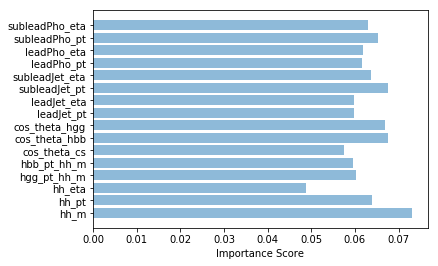

In [45]:
#features importance
clf=joblib.load('clf_accuSM9.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [46]:
#optimised based on accuracy for 4 
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,30)
w_train*=rw[y_train-1]

np.savetxt('rw_accu4.txt',rw)

clf=XGBClassifier(learning_rate=0.5, reg_lambda=10, subsample=1, max_depth=10, n_estimators=800, 
                  min_child_weight=20, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_accu4.joblib') 

CPU times: user 9min 40s, sys: 4.41 s, total: 9min 45s
Wall time: 1min 13s


['clf_accu4.joblib']

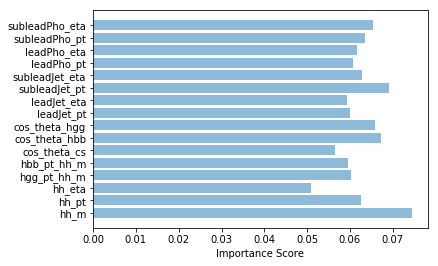

In [47]:
#features importance
clf=joblib.load('clf_accu4.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [48]:
#optimised based on accuracy for 6 
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train-1]

np.savetxt('rw_accu6.txt',rw)

clf=XGBClassifier(learning_rate=0.5, reg_lambda=2, subsample=0.8, max_depth=10, n_estimators=300, 
                  min_child_weight=20, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_accu6.joblib') 

CPU times: user 4min 26s, sys: 2.9 s, total: 4min 28s
Wall time: 33.7 s


['clf_accu6.joblib']

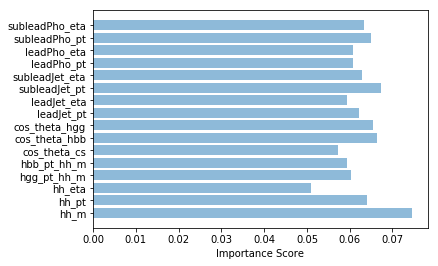

In [49]:
#features importance
clf=joblib.load('clf_accu6.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [50]:
#optimised based on accuracy for merged
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,30)
w_train*=rw[y_train-1]

np.savetxt('rw_accumerged.txt',rw)

clf=XGBClassifier(learning_rate=0.1, reg_lambda=2, subsample=1, max_depth=3, n_estimators=300, 
                  min_child_weight=200, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_accumerged.joblib') 

CPU times: user 1min 44s, sys: 712 ms, total: 1min 45s
Wall time: 13.2 s


['clf_accumerged.joblib']

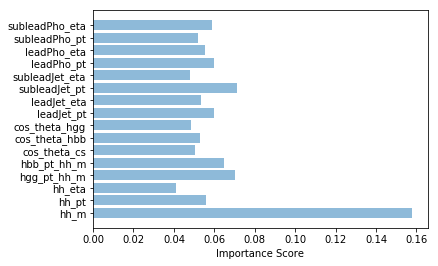

In [51]:
#features importance
clf=joblib.load('clf_accumerged.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [52]:
#optimised based on entropy for SM,4,6
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train-1]

np.savetxt('rw_crossSM46.txt',rw)

clf=XGBClassifier(learning_rate=0.1, reg_lambda=10, subsample=0.6, max_depth=10, n_estimators=800, 
                  min_child_weight=20, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_crossSM46.joblib') 

CPU times: user 14min 19s, sys: 7.31 s, total: 14min 26s
Wall time: 1min 48s


['clf_crossSM46.joblib']

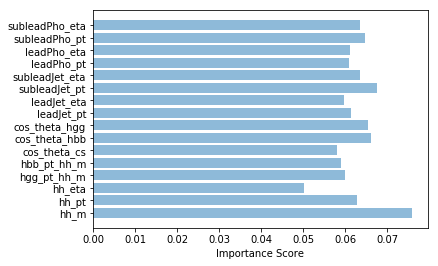

In [53]:
#features importance
clf=joblib.load('clf_crossSM46.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [59]:
#optimised based on entropy for 9 and merged
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

h=np.histogram(y_train,weights=w_train,bins=bins)
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,30)
w_train*=rw[y_train-1]

np.savetxt('rw_cross9merged.txt',rw)

clf=XGBClassifier(learning_rate=0.1, reg_lambda=2, subsample=1, max_depth=3, n_estimators=300, 
                  min_child_weight=200, n_jobs=8, objective='multi:softmax')
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_cross9merged.joblib') 

CPU times: user 1min 46s, sys: 1.02 s, total: 1min 47s
Wall time: 13.4 s


['clf_cross9merged.joblib']

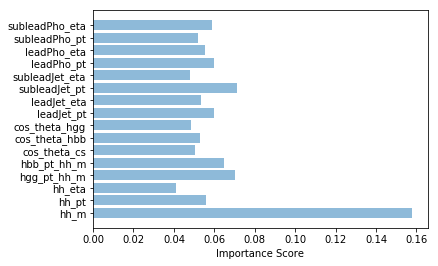

In [60]:
#features importance
clf=joblib.load('clf_cross9merged.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()